# Machine Learning tutorial (#mltutorial):
1. How to download and load COBRE resting state functional datasets.
2. How to measure connectomes from brain data decomposed to functionally
   defined regions.
3. SVM based classification of healthy subjects and schizophrenic datasets

All methods are adapted from Nilearn, a Python based toolbox developed for
resting state analysis of Brain data. Nilearn is heavily dependent on scikit-learn machine learning library http://scikit-learn.org/stable/, numpy, scipy and matplotlib.

In [1]:
%matplotlib inline

###Loading resting state functional datasets

To fetch the datasets, we take the opportunity of datasets module developed in nilearn package for easy download and fetching of all datasets. This can be done by simply importing datasets module and fetching the selected datasets.

In this tutorial, we are interested to select COBRE datasets.

In [2]:
from gemini import datasets as cobre_datasets

data_dir = '/home/kamalakar/Kamalakar/work'
data = cobre_datasets.fetch_COBRE(data_dir=data_dir)

# To see the files fetched related to the datasets.
print data.keys()

# Anatomical datasets
anatomical_datasets = data.anatomical
# Functional datasets
functional_datasets = data.functional
n_datasets = len(functional_datasets)
print "Total functional datasets of %d subjects are fetched and loaded." % n_datasets
# Phenotypic or demographic variables
phenotypic = data.phenotypic

print functional_datasets[0] # to check the location of the data storage

['phenotypic', 'functional', 'anatomical']
Total functional datasets of 81 subjects are fetched and loaded.
/home/kamalakar/Kamalakar/work/COBRE/0040090/session_1/rest_1/wrarest.nii.gz


#### NOTE: All the datasets are stored locally and nilearn is comfortable processing data by giving the paths of the data storage location. 

###Loading pre-generated functional parcellations of 39 brain regions

We use Multi-subject dictionary learning (MSDL) atlas, multi subject model developed using resting state functional datasets of multiple number of subjects. We use the same import datasets where variety of pre-generated atlases can be fetched easily.

In [3]:
from nilearn import datasets

msdl_atlas = datasets.fetch_atlas_msdl()
atlas_filename = msdl_atlas['maps'] # Brain functional maps/regions
atlas_labels = msdl_atlas['labels'] # Labels defined for 39 brain maps

# To see the Bunch of files fetched related to the atlas
print msdl_atlas['maps'] # path location saved in local directory
print msdl_atlas['labels'] # path location saved in local directory
print msdl_atlas['description'] # details about the atlas maps

# Load the labels into an array. We import numpy utilities to load them
import numpy
labels = numpy.recfromcsv(atlas_labels)

print labels['name'] # To list the names of brain regions in parcellations

/home/kamalakar/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii
/home/kamalakar/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois_labels.csv
MSDL atlas


Notes
-----
Result maps of sparse dictionary learning based on resting-state data.

This can be understand as a variant of ICA based on the assumption
of sparsity rather than independence.


Content
-------
    :'maps': Nifti images with the (probabilistic) region definitions
    :'labels': CSV file specifying the label information


References
----------
For more information about this dataset's structure:
https://team.inria.fr/parietal/research/spatial_patterns/spatial-patterns-in-resting-state/

Multi-subject dictionary learning to segment an atlas of brain spontaneous activity Gaël Varoquaux, Alexandre Gramfort, Fabian Pedregosa, Vincent Michel, Bertrand Thirion Information Processing in Medical Imaging, 2011, pp. 562-573, Lecture Notes in Computer Science

Learning and comparing functional connectomes across subjects. Gaël Varoquaux, R

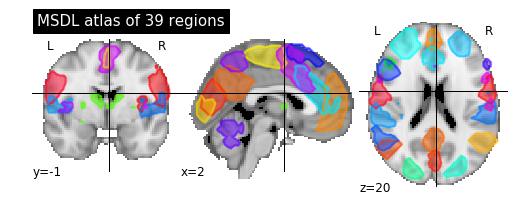

In [4]:
# To view the atlas, we can use of nilearn plotting utilities to see what has
# been fetched and how does it look like. For this, we import plotting and use
# `plot_prob_atlas` to visualize the 4D atlas maps, 4D since we have 39 regions.
from nilearn import plotting

plotting.plot_prob_atlas(atlas_filename, view_type='filled_contours',
                         title='MSDL atlas of 39 regions')
plotting.show() # No need to import matplotlib functions separately to show the results

###Extracting subject specific timeseries signals from brain parcellations

Computing mask from the data, filtering, extracting data from the in-mask voxels can be processed easily by using nilearn classes such as NiftiMasker, NiftiMapsMasker, NiftiLabelsMasker which can be imported from nilearn.input_data module.

The advantage of using such tools from this module is that we can restrict our analysis to mask specific voxels timeseries data. For instance, class `NiftiMasker` can be used to compute mask over the data and apply preprocessing steps such as filtering, smoothing, standardizing and detrending on voxels timeseries signals. This type of processing is very much necessary, particularly during resting state fMRI data analysis.

Additional to `NiftiMasker`, classes `NiftiMapsMasker` and `NiftiLabelsMasker`, can be used to extract subject specific timeseries signals on each subject data provided with the atlas maps (3D or 4D) comprising of specific brain regions. `NiftiMapsMasker` operated on 4D atlas maps, can be used to extract signals from each 4th dimensional map using least squares regression. Whereas, `NiftiLabelsMasker` operated on 3D maps denoted as labels image, can be used to extract averaged timeseries from group of voxels that correponds to each label in the image.


In [5]:
# Import and initialize `NiftiMapsMasker` object and call `fit_transform` to
# extract timeseries signals from provided MSDL functional atlas.
from nilearn.input_data import NiftiMapsMasker
from nilearn.image import high_variance_confounds
from nilearn._utils import check_niimg

# The parameters used are maps_img as parcellations, resampling to maps image,
# smoothing of 6mm, detrending, standardizing and filtering (TR in sec). These later
# parameters are applied automatically when extracting timeseries data.
maps_masker = NiftiMapsMasker(maps_img=atlas_filename, resampling_target='maps',
                              smoothing_fwhm=6, standardize=True, detrend=True,
                              t_r=2.5, low_pass=0.1, high_pass=0.01)

print maps_masker # to see the initialization of the parameters.


NiftiMapsMasker(allow_overlap=True, detrend=True, high_pass=0.01,
        low_pass=0.1,
        maps_img='/home/kamalakar/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii',
        mask_img=None, memory=Memory(cachedir=None), memory_level=0,
        resampling_target='maps', smoothing_fwhm=6, standardize=True,
        t_r=2.5, verbose=0)


In [8]:
# We loop over all the functional datasets to compute confounds for each subject
# data and simultaneously used with other preprocessing parameters to clean
# timeseries signals data.
subjects_timeseries = []
for each_dataset in functional_datasets:
    print "Loading as Nifti-like image object from each subject path, filename:%s" % each_dataset
    subject_img = check_niimg(each_dataset) # Converting filename to Nifti like image data
    print "Computing confounds"
    confound = high_variance_confounds(subject_img, n_confounds=3)
    print "Extracting timeseries signals from loaded image %s using maps masker object" % each_dataset
    signals = maps_masker.fit_transform(subject_img, confounds=confound)
    subjects_timeseries.append(signals)

print  "Finished extracting timeseries signals for each subject"
print "Array subjects_timeseries contains list of '%d' subject specific timeseries signals" % len(subjects_timeseries)

Loading as Nifti-like image object from each subject path, filename:/home/kamalakar/Kamalakar/work/COBRE/0040090/session_1/rest_1/wrarest.nii.gz
Computing confounds
Extracting timeseries signals from loaded image /home/kamalakar/Kamalakar/work/COBRE/0040090/session_1/rest_1/wrarest.nii.gz using maps masker object
Loading as Nifti-like image object from each subject path, filename:/home/kamalakar/Kamalakar/work/COBRE/0040117/session_1/rest_1/wrarest.nii.gz
Computing confounds
Extracting timeseries signals from loaded image /home/kamalakar/Kamalakar/work/COBRE/0040117/session_1/rest_1/wrarest.nii.gz using maps masker object
Loading as Nifti-like image object from each subject path, filename:/home/kamalakar/Kamalakar/work/COBRE/0040000/session_1/rest_1/wrarest.nii.gz
Computing confounds
Extracting timeseries signals from loaded image /home/kamalakar/Kamalakar/work/COBRE/0040000/session_1/rest_1/wrarest.nii.gz using maps masker object
Loading as Nifti-like image object from each subject pa

/home/kamalakar/Kamalakar/work/nilearn/nilearn/image/resampling.py:463: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [9]:
# Visualizing extracted timeseries signals. We import matplotlib.pyplot
import matplotlib.pyplot as plt

# We show only for one subject
timeseries = subjects_timeseries[0]
print timeseries.shape # (number of scans/time points, number of brain regions/parcellations)
plt.plot(timeseries)
plt.title('Timeseries for single subject shown for 39 brain regions')
plt.xlabel('Number of scans')
plt.ylabel('Normalized signal')
plt.show()

(150, 39)


### Connectomes Estimation

Computing connectomes using connectivity measures such as correlation, partial correlation and tangent methods with Ledoit Wolf shrinkage covariance estimator. We import class `ConnectivityMeasure` from nilearn.connectome module and covariance estimator `LedoitWolf` from scikit learn to measure connectomes using extracted subjects timeseries signals between each brain parcellations.

In [10]:
# Here, we depend on scikit-learn library on covariance estimator, LedoitWolf
from sklearn.covariance import LedoitWolf
from nilearn.connectome import ConnectivityMeasure, sym_to_vec

print "Measuring Connectivity"
connectivity_matrices = {}
measures = ['correlation', 'partial correlation', 'tangent']
for measure in measures:
    print "Estimating %s matrices" % measure
    connectivity = ConnectivityMeasure(cov_estimator=LedoitWolf(assume_centered=True),
                                       kind=measure)
    connectivity_matrices[measure] = connectivity.fit_transform(subjects_timeseries)

print "Finished Measuring Connectomes"

Measuring Connectivity
Estimating correlation matrices
Estimating partial correlation matrices
Estimating tangent matrices
Finished Measuring Connectomes


###Plotting connectome matrices

Plotting connectome matrices. We calculate mean of all the matrices of each measure and use mean matrices to visualize the connectome interactions between 39 brain atlas regions. We make use of plotting from nilearn which is already imported.

Calculate mean of all the connectivity matrices for each measure. For tangent based measure, mean is already pre-computed during connectivity measures. So, we directly take mean in `mean_` attribute and for other measures we compute voluntarily.

In [11]:
mean_connectivity_matrices = {}
region_coords = labels[['x', 'y', 'z']].tolist() # We take coordinates of brain regions stored in labels
for measure in measures:
    if measure == 'tangent':
        mean_connectivity_matrices[measure] = connectivity.mean_
    else:
        mean_connectivity_matrices[measure] = connectivity_matrices[measure].mean(axis=0)
    # Visualizing goes here
    plotting.plot_connectome(mean_connectivity_matrices[measure], region_coords, edge_threshold='98%',
                             title='Mean connectivity of %s measure' % measure)
    
plotting.show()

###Computing connectivity coefficients

We have shown how to measure connectomes of three different types. Now, we compute connectivity coefficients from those measures and use the coefficients to classify samples between schizophrenia and healthy subjects.

Our classification is based on Support Vector Machine linear classifier and at the same time using Stratified Shuffle Split mechanism where we train the classifier by 75% of the data size and test the classifier on the remaining 25% of the data size. This process we continue to iterate for 100 iterations. We capture and show the percentage of classifier accuracy using cross validation setting, more specifically we show the mean of roc and auc classification scores.

In this classifier setting, we will be heavily be dependent on scikit-learn library which has cool and easy to use machine learning classifiers useful for Neuroimaging community.

In [12]:
# We import SVC, StratifiedShuffleSplit, cross_val_score from scikit learn for
# classification problem using cross validation procedure and import sym_to_vec
# from nilearn.connectome module to compute connectivity coefficients for each
# measure to use them in classification.
from nilearn.connectome import sym_to_vec
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedShuffleSplit, cross_val_score

print "Classification using Support Vector Linear Classifier"
for measure in measures:
    print "Computing connectivity coefficients"
    connectivity_coefs = sym_to_vec(connectivity_matrices[measure])
    print "Support Vector Classification"
    # Get the phenotypic variables of Subject type for classification
    classes = phenotypic['Subject Type'].values
    # Initialize Stratified Shuffle Split with 100 iterations and test size
    stratified_shuffle = StratifiedShuffleSplit(classes, n_iter=100,
                                                test_size=0.25, random_state=0)
    svc = SVC(kernel='linear', class_weight='balanced', random_state=0)
    print "Classification scores using Area Under Curve"
    _, classes_ = numpy.unique(classes, return_inverse=True)
    cross_validation = cross_val_score(svc, connectivity_coefs, classes_,
                                       scoring='roc_auc', cv=stratified_shuffle)
    print "Classification scores %s: %1.2f +/- %1.2f" % (measure, cross_validation.mean(),
                                                         cross_validation.std())


Classification using Support Vector Linear Classifier
Computing connectivity coefficients
Support Vector Classification
Classification scores using Area Under Curve
Classification scores correlation: 0.72 +/- 0.09
Computing connectivity coefficients
Support Vector Classification
Classification scores using Area Under Curve
Classification scores partial correlation: 0.63 +/- 0.10
Computing connectivity coefficients
Support Vector Classification
Classification scores using Area Under Curve
Classification scores tangent: 0.75 +/- 0.08
